이미지 크기 차이가 나는건 일단 어찌해결할지 생각이 안남.  
box를 자를 때 비율이 맞도록 자르는 방법?  
근데 원래 이미지 자체가 비율이 안맞는데(누워있거나 서있거나) 어려울 것 같다.

우선 augmentation은 쓰지 않고, 기본 성능을 측정해보자

test는 누워서 하는 동작이 절반인데 train에선 별로 없고, 사람도 다름  
철봉 운동에서 일부 손이 짤린게 있음

여담이지만, horizontal flip을 하게되면 거울효과처럼 keypoint의 좌표를 flip한 뒤 오른손/왼손을 서로 뒤바꿔줘야함

---

## 라이브러리 로딩

In [1]:
%load_ext lab_black

In [2]:
import math
import os
import random
import shutil
import json
import logging
import sys
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm
from PIL import Image

import utils
import networks
from error_list import error_list

---

## 하이퍼 파라미터

In [3]:
RESULT_DIR = Path("results/HRNet학습-box_effdet")

In [4]:
LR = 1e-4  # transfer learning이니깐 좀 작게 주는게 좋을 것 같아서 1e-4
BATCH_SIZE = 10
START_EPOCH = 1
SAM = False
FOLD = 1
HRNET_WIDTH = 48
AUG_HORIZONTAL_FLIP = True
AUG_SHIFT = True
NORMALIZE = False

In [5]:
n = datetime.now()
UID = f"{n.year:04d}{n.month:02d}{n.day:02d}-{n.hour:02d}{n.minute:02d}{n.second:02d}"
SEED = 20210309

MEAN = torch.tensor((0.485, 0.456, 0.406), dtype=torch.float32).reshape(3, 1, 1)
STD = torch.tensor((0.229, 0.224, 0.225), dtype=torch.float32).reshape(3, 1, 1)

In [6]:
utils.seed_everything(SEED, deterministic=False)
RESULT_DIR.mkdir(parents=True, exist_ok=True)
log = utils.CustomLogger(RESULT_DIR / f"log_{UID}.log", "a")
log.info("학습 시작")
log.info("UID:", UID)
log.info("SEED:", SEED)
log.info("LR:", LR)
log.info("BATCH_SIZE:", BATCH_SIZE)
log.info("START_EPOCH:", START_EPOCH)
log.info("SAM:", SAM)
log.info("FOLD:", FOLD)
log.info("HRNET_WIDTH:", HRNET_WIDTH)
log.info("AUG_HORIZONTAL_FLIP:", AUG_HORIZONTAL_FLIP)
log.info("AUG_SHIFT:", AUG_SHIFT)

[2021-03-14 13:23:44  INFO] 학습 시작
[2021-03-14 13:23:44  INFO] UID: 20210314-132344
[2021-03-14 13:23:44  INFO] SEED: 20210309
[2021-03-14 13:23:44  INFO] LR: 0.0001
[2021-03-14 13:23:44  INFO] BATCH_SIZE: 10
[2021-03-14 13:23:44  INFO] START_EPOCH: 1
[2021-03-14 13:23:44  INFO] SAM: False
[2021-03-14 13:23:44  INFO] FOLD: 1
[2021-03-14 13:23:44  INFO] HRNET_WIDTH: 48
[2021-03-14 13:23:44  INFO] AUG_HORIZONTAL_FLIP: True
[2021-03-14 13:23:44  INFO] AUG_SHIFT: True


---

## 데이터 로딩

In [20]:
train_imdir = Path("data/box_effdet2/train_imgs/")
test_imdir = Path("data/box_effdet2/test_imgs/")

In [21]:
df = pd.read_csv("data/box_effdet2//train_df.csv")
keypoints = df.to_numpy()[:, 1:].astype(np.float32)
keypoints = np.stack([keypoints[:, 0::2], keypoints[:, 1::2]], axis=2)

In [22]:
with open("data/box_effdet2/offset.json", "r") as f:
    offsets = json.load(f)

### 잘못 매칭된 키포인트를 갖고있는 파일들 제거

감사합니다 최정명님

In [23]:
offsets_ = []
keypoints_ = []
for i, (offset, keypoint) in enumerate(zip(offsets["train"], keypoints)):
    if i not in error_list:
        offsets_.append(offset)
        keypoints_.append(keypoint)

print(len(offsets["train"]), len(offsets_), len(keypoints), len(keypoints_))

4195 4094 4195 4094


In [24]:
offsets["train"] = offsets_
keypoints = np.stack(keypoints_)

In [25]:
c2i = {c: i for i, c in enumerate(df.columns[1:])}
swap_columns = []
for i, c in enumerate(df.columns[1:]):
    if c.startswith("left_") and c.endswith("_x"):
        swap_columns.append((i // 2, c2i["right_" + c[5:]] // 2))


def horizontal_flip(x, keypoints, p=0.5):
    if random.random() > p:
        return x, keypoints

    dx = torch.flip(x, dims=(2,))
    maxw = x.size(2) // 4
    keypoints[:, 0] = maxw - keypoints[:, 0]
    for a, b in swap_columns:
        temp = keypoints[a].clone()
        keypoints[a] = keypoints[b].clone()
        keypoints[b] = temp

    return dx, keypoints

In [26]:
def random_shift(x, keypoints, distance=20, p=0.5):
    if random.random() > 1:
        return x, keypoints

    _, H, W = x.shape

    # distance = min(keypoints[:, 0].min(), W - keypoints[:, 0].max(), keypoints[:, 1].min(), H - keypoints[:, 1].max())
    # print(distance)

    # yp = random.randint(-distance, distance)
    # xp = random.randint(-distance, distance)
    xp = random.randint(-8, 8)
    yp = random.randint(-24, 24)
    keypoints[:, 0] += xp // 4
    keypoints[:, 1] += yp // 4

    dx = torch.zeros_like(x)
    dxl = xp if xp >= 0 else 0
    dxr = W if xp >= 0 else W + xp
    dxt = yp if yp >= 0 else 0
    dxb = H if yp >= 0 else H + yp
    xl = 0 if xp >= 0 else -xp
    xr = W - xp if xp >= 0 else W
    xt = 0 if yp >= 0 else -yp
    xb = H - yp if yp >= 0 else H
    dx[..., dxt:dxb, dxl:dxr] = x[..., xt:xb, xl:xr]

    return dx, keypoints

In [32]:
class ImageDataset(Dataset):
    def __init__(self, imdir, offsets, keypoints=None, augmentation=True):
        super().__init__()
        self.imdir = Path(imdir)
        self.offsets = offsets
        self.keypoints = keypoints
        self.augmentation = augmentation

    def __len__(self):
        return len(self.offsets)

    def __getitem__(self, idx):
        f = self.imdir / self.offsets[idx]["image"]
        x = imageio.imread(f)
        H, W, _ = x.shape

        # TODO 가로로 긴 영상이면 가로 길이가 768이 되도록 만들기
        # 지금은 그냥 576x768로 resize해서 왜곡이 생겨서 성능 악화가 있을거 같음
        x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Standardization. HRNet도 standardization 하고 있음.
        # Pretrained weight를 제대로 쓰고 싶다면 standardization은 필수
        if NORMALIZE:
            x = (x - MEAN) / STD

        # box값으로 전체 이미지에 대한 keypoint와 국소 keypoint로 서로 왕래할 수 있음
        ratio = torch.tensor(self.offsets[idx]["ratio"], dtype=torch.float32)
        offset = torch.tensor(self.offsets[idx]["boxes"][:2], dtype=torch.int64)

        if self.keypoints is not None:
            keypoint = torch.tensor(self.keypoints[idx], dtype=torch.float32)
            keypoint[:, 0] = (keypoint[:, 0] - offset[0]) * ratio / 4
            keypoint[:, 1] = (keypoint[:, 1] - offset[1]) * ratio / 4
            keypoint = keypoint.type(torch.int64)

            # Augmentation
            if self.augmentation:
                if AUG_HORIZONTAL_FLIP:
                    x, keypoint = horizontal_flip(x, keypoint, p=0.5)
                if AUG_SHIFT:
                    x, keypoint = random_shift(x, keypoint, p=0.5)

            """
            # 좌표값 keypoint를 24차원 평면으로 변환 --> L1 loss
            y = torch.zeros(24, 768 // 4, 576 // 4, dtype=torch.int64)
            for i in range(24):
                y[i, keypoint[i, 1] // 4, keypoint[i, 0] // 4] = 1
            """
            # 좌표값 keypoint를 1차원 벡터의 위치 값으로 변환 --> 각 keypoint마다 cross entropy 이후 reduction.
            # TODO cross entropy는 가로세로 위치에 대한 영향은 신경쓰지 않음. 이 부분 어찌 향상시킬 방법 없을까?
            y = keypoint[:, 0] + keypoint[:, 1] * (576 // 4)

            return f.name, x, offset, ratio, y
        return f.name, x, offset, ratio

In [33]:
ds_train_total = ImageDataset(train_imdir, offsets["train"], keypoints, augmentation=False)
ds_test = ImageDataset(test_imdir, offsets["test"])

In [34]:
dl_kwargs = dict(batch_size=BATCH_SIZE, num_workers=4)

### 데이터셋 잘 만들어졌는지 검증

In [35]:
def tensor2image(x):
    if NORMALIZE:
        x = x * STD + MEAN
    return (x.permute(1, 2, 0) * 255.0).type(torch.uint8).numpy()

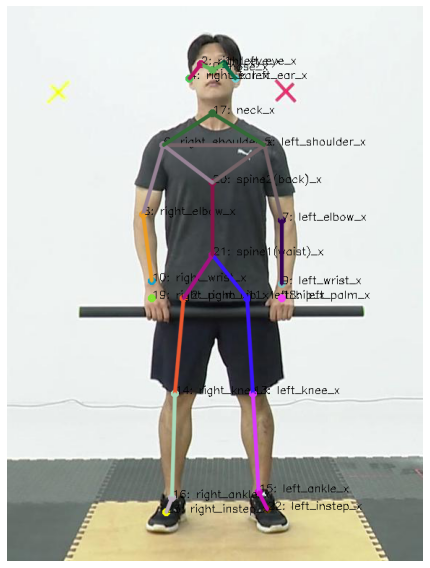

In [36]:
f, x, offset, ratio, y = ds_train_total[1980]
out_img = tensor2image(x)
utils.draw_keypoints_show(out_img, utils.nums2keypoints(y) * 4)

### 잘못 변환된 keypoint가 있는지 확인

In [37]:
for f, x, offset, ratio, y in tqdm(ds_train_total, ncols=100, file=sys.stdout):
    _, H, W = x.shape
    y = utils.nums2keypoints(y) * 4
    left = y[:, 0].min()
    right = y[:, 0].max()
    top = y[:, 1].min()
    bottom = y[:, 1].max()
    if left < 0 or right > W:
        print(f)
        break
    if top < 0 or bottom > H:
        print(f)
        break

100%|██████████████████████████████████████████████████████████| 4094/4094 [00:17<00:00, 232.33it/s]


---

## 학습 준비

학습은 crossentropy, 학습 중간에 RMSE 표시

In [21]:
model = networks.PoseHighResolutionNet(width=HRNET_WIDTH)

In [18]:
model.load_state_dict(torch.load(f"networks/models/pose_hrnet_w{HRNET_WIDTH}_384x288.pth"))

<All keys matched successfully>

In [22]:
final_layer = nn.Conv2d(HRNET_WIDTH, 24, 1)
with torch.no_grad():
    final_layer.weight[:17] = model.final_layer.weight
    final_layer.bias[:17] = model.final_layer.bias
model.final_layer = final_layer

In [23]:
model = model.cuda()

In [71]:
if SAM:
    optimizer = utils.SAM(model.parameters(), optim.AdamW, lr=LR)
else:
    optimizer = optim.AdamW(model.parameters(), lr=LR)

In [24]:
class KeypointLoss(nn.Module):
    def forward(self, x, y):
        x = x.flatten(2).flatten(0, 1)
        y = y.flatten()
        return F.cross_entropy(x, y)
        """
        x = F.log_softmax(x.flatten(2), dim=2)
        y = y.flatten(2)
        return (y - x).mean()
        """

In [25]:
class KeypointRMSE(nn.Module):
    @torch.no_grad()
    def forward(self, x, y):
        W = x.size(3)
        xp = x.flatten(2).argmax(2)
        xx, xy = xp % W, xp // W
        yx, yy = y % W, y // W
        return 4 * ((xx - yx) ** 2 + (xy - yy) ** 2).type(torch.float32).mean().sqrt()

In [74]:
criterion = KeypointLoss().cuda()
criterion_rmse = KeypointRMSE().cuda()

In [75]:
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)

---

## 학습

In [76]:
def train_loop(dl: DataLoader):
    torch.cuda.empty_cache()
    model.train()

    meanloss = utils.AverageMeter()
    meanrmse = utils.AverageMeter()
    results = {"image": [], "loss": [], "rmse": []}
    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout, desc=f"Train[{epoch:03d}]") as t:
        for f, x, offset, ratio, y in dl:
            x_ = x.cuda()
            y_ = y.cuda()
            p_ = model(x_)
            loss = criterion(p_, y_)
            rmse = criterion_rmse(p_, y_)

            optimizer.zero_grad()
            loss.backward()
            if isinstance(optimizer, utils.SAM):
                optimizer.first_step()
                loss = criterion(model(x_), y_).backward()
                optimizer.second_step()
            else:
                optimizer.step()

            meanloss.update(loss.item())
            meanrmse.update(rmse.item())
            results["image"].append(f)
            results["loss"].append(loss.item())
            results["rmse"].append(rmse.item())
            t.set_postfix_str(f"loss: {loss.item():.6f}, rmse: {rmse.item():.6f}", refresh=False)
            t.update(len(x))

    return meanloss(), meanrmse(), results

In [77]:
@torch.no_grad()
def valid_loop(dl: DataLoader):
    torch.cuda.empty_cache()
    model.eval()

    meanloss = utils.AverageMeter()
    meanrmse = utils.AverageMeter()
    results = {"image": [], "loss": [], "rmse": []}
    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout, desc=f"Valid[{epoch:03d}]") as t:
        for f, x, offset, ratio, y in dl:
            x_ = x.cuda()
            y_ = y.cuda()
            p_ = model(x_)
            loss = criterion(p_, y_)
            rmse = criterion_rmse(p_, y_)

            meanloss.update(loss.item())
            meanrmse.update(rmse.item())
            results["image"].append(f)
            results["loss"].append(loss.item())
            results["rmse"].append(rmse.item())
            t.set_postfix_str(f"loss: {loss.item():.6f}, rmse: {rmse.item():.6f}", refresh=False)
            t.update(len(x))

    return meanloss(), meanrmse(), results

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [21]:
train_idx, valid_idx = list(kf.split(ds_train_total))[FOLD - 1]

ds_train = Subset(ds_train_total, train_idx)
ds_valid = Subset(ds_train_total, valid_idx)
dl_train = DataLoader(ds_train, **dl_kwargs, shuffle=True)
dl_valid = DataLoader(ds_valid, **dl_kwargs, shuffle=False)

best_loss = math.inf
early_stop_cnt = 0

In [80]:
for epoch in range(START_EPOCH, 999):
    tloss, trmse, tres = train_loop(dl_train)
    vloss, vrmse, vres = valid_loop(dl_valid)

    # Logging
    log.info(f'Epoch: {epoch:03d}, loss: {tloss:.6f} ; {vloss:.6f}, rmse {trmse:.6f} ; {vrmse:.6f}')
    scheduler.step(vloss)

    # Earlystop
    if vloss < best_loss:
        best_loss = vloss
        early_stop_cnt = 0

        with open(RESULT_DIR/f'loss-{UID}.json', 'w') as f:
            json.dump({'train': tres, 'valid': vres}, f)

        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
        }, RESULT_DIR/f'ckpt-{UID}_{FOLD}.pth')
    elif early_stop_cnt >= 10:
        log.info(f'Stop training at epoch {epoch}.')
        break
    else:
        early_stop_cnt +=1

[2021-03-14 13:39:42  INFO] Epoch: 001, loss: 6.924962 ; 4.776136, rmse 157.903569 ; 94.153855
[2021-03-14 13:44:15  INFO] Epoch: 002, loss: 4.055766 ; 3.739934, rmse 58.545908 ; 39.664346
[2021-03-14 13:48:49  INFO] Epoch: 003, loss: 3.330926 ; 3.487792, rmse 31.535077 ; 31.555519
[2021-03-14 13:53:22  INFO] Epoch: 004, loss: 2.939226 ; 3.390637, rmse 24.168799 ; 28.336537


Traceback (most recent call last):
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/shim/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 404, in

KeyboardInterrupt: 

In [37]:
iterr = dl_train.__iter__()

In [39]:
f, x, offset, ratio, y = next(iterr)

In [44]:
y.min()

tensor(-652)

TODO: criterion을 L1을 써보기

---

## 검증

In [26]:
torch.set_grad_enabled(False)
ckpt = torch.load("results/HRNet학습-box_effdet/ckpt-20210314-232231-no_normalize_1.pth")
model.load_state_dict(ckpt["model"])
model.eval()
pass

### 학습 데이터

In [27]:
f, x, offset, ratio, y = ds_train_total[1000]

In [28]:
x = tensor2image(x)
y = utils.nums2keypoints(y) * 4

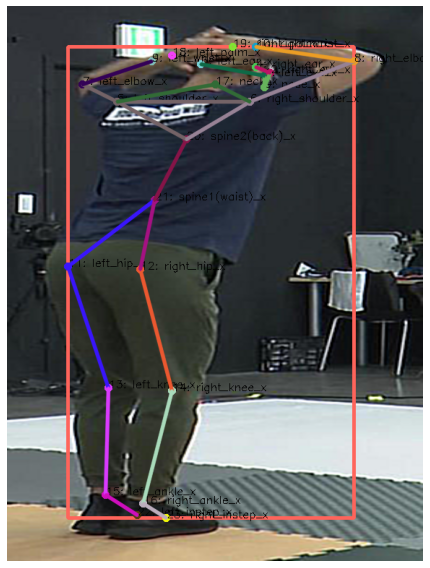

In [29]:
utils.draw_keypoints_show(x, y)

### Validation 한 epoch 시행

In [30]:
@torch.no_grad()
def valid_loop(dl: DataLoader):
    torch.cuda.empty_cache()
    model.eval()

    out_dir = Path("results/HRNet학습결과-box_effdet/valid-20210314-232231-no_normalize_1")
    out_dir.mkdir(parents=True, exist_ok=True)

    meanloss = utils.AverageMeter()
    meanrmse = utils.AverageMeter()
    results = {"image": [], "loss": [], "rmse": []}

    i = 0

    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout, desc=f"Valid[{epoch:03d}]") as t:
        for f, x, offset, ratio, y in dl:
            x_ = x.cuda()
            y_ = y.cuda()
            p_ = model(x_)
            loss = criterion(p_, y_)
            rmse = criterion_rmse(p_, y_)

            meanloss.update(loss.item(), len(x))
            meanrmse.update(rmse.item(), len(x))
            results["image"].append(f)
            results["loss"].append(loss.item())
            results["rmse"].append(rmse.item())
            t.set_postfix_str(f"loss: {loss.item():.6f}, rmse: {rmse.item():.6f}", refresh=True)

            # 결과물을 이미지로 저장
            p = p_.cpu()
            for df, dx, dp, dy in zip(f, x, p, y):
                df = Path(df)
                img = tensor2image(dx)
                real_kps = utils.nums2keypoints(dy) * 4
                pred_kps = utils.channel2point(dp)  # 내부에서 이미 4를 곱하니깐 곱해줄 필요 없음
                real_img = utils.draw_keypoints(img, real_kps)
                pred_img = utils.draw_keypoints(img, pred_kps)
                imageio.imwrite(out_dir / f"{df.stem}_real.jpg", real_img)
                imageio.imwrite(out_dir / f"{df.stem}_pred_{rmse.item():.6f}.jpg", pred_img)

                i += 1
                t.update()

    return meanloss(), meanrmse(), results

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [32]:
train_idx, valid_idx = list(kf.split(ds_train_total))[FOLD - 1]
ds_valid = Subset(ds_train_total, valid_idx)
dl_valid = DataLoader(ds_valid, **dl_kwargs, shuffle=False)

In [33]:
criterion = KeypointLoss().cuda()
criterion_rmse = KeypointRMSE().cuda()

In [34]:
epoch = 1
vloss, vrmse, vres = valid_loop(dl_valid)
print(f"loss {vloss:.6f}, rmse {vrmse:.6f}")

loss 3.465263, rmse 26.948182                                                                       


In [62]:
epoch = 1
vloss, vrmse, vres = valid_loop(dl_valid)
print(f"loss {vloss:.6f}, rmse {vrmse:.6f}")

loss 3.347115, rmse 25.771639                                                                       


여전히 RMSE가 100을 가끔 넘기는게 있음  
이런게 쌓여서 valid랑 submission의 평균 RMSE가 차이나는게 아닐지?

### 예측 데이터 (test)

In [35]:
dl_test = DataLoader(ds_test, **dl_kwargs, shuffle=False)

In [36]:
f, x, offset, ratio = next(dl_test.__iter__())

In [37]:
p = model(x.cuda()).cpu()

In [38]:
p.shape

torch.Size([10, 24, 192, 144])

In [39]:
im = tensor2image(x[9])

In [40]:
keypoint = utils.channel2point(p[9])

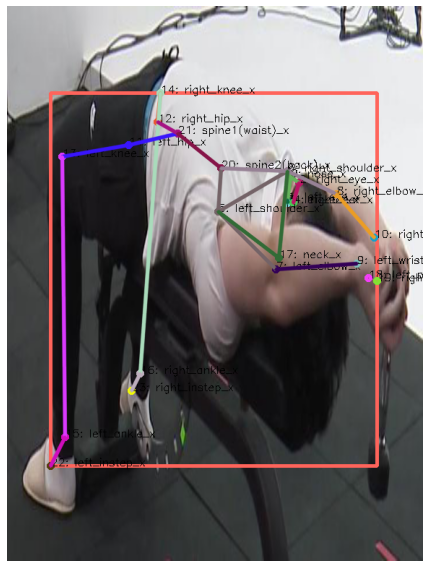

In [41]:
utils.draw_keypoints_show(im, keypoint)

---

## 서브미션 만들기

In [42]:
sample_submission = pd.read_csv("data/ori/sample_submission.csv")

### 채크포인트 하나

위쪽에서 체크포인트 로딩 했으니깐 다시 로딩하지는 않음

### KFold

In [43]:
ckpt_files = [f"results/HRNet학습-box_effdet/ckpt-20210314-232231-no_normalize_{i}.pth" for i in [1, 2, 3, 4, 5]]

In [44]:
torch.set_grad_enabled(False)
model.eval()

results = []
for fold in range(1, 6):
    model.load_state_dict(torch.load(ckpt_files[fold - 1])["model"])
    torch.cuda.empty_cache()

    out_dir = Path(f"results/HRNet학습결과-box_effdet/test-20210314-232231-no_normalize_{fold}")
    out_dir.mkdir(parents=True, exist_ok=True)

    result = []
    with tqdm(total=len(dl_test.dataset), ncols=100, file=sys.stdout) as t:
        for fs, xs, offsets, ratios in dl_test:
            ps = model(xs.cuda()).cpu()
            for f, x, p, offset, ratio in zip(fs, xs, ps, offsets, ratios):
                pos = utils.channel2point(p).astype(np.float64)
                pos[:, 0] = pos[:, 0] / ratio[0] + offset[0]
                pos[:, 1] = pos[:, 1] / ratio[1] + offset[1]
                out = np.concatenate([[f], pos.flatten()])
                result.append(out)

                # 출력물 이미지로 저장
                f = Path(f)
                img = (x.permute(1, 2, 0) * 255.0).type(torch.uint8).numpy()
                kps = utils.channel2point(p)  # 내부에서 이미 4를 곱하니깐 곱해줄 필요 없음
                kps_img = utils.draw_keypoints(img, kps)
                imageio.imwrite(out_dir / f"{f.stem}.jpg", kps_img)

                t.set_postfix_str(f)
                t.update()
    result = np.stack(result)
    results.append(result)
    df_out = pd.DataFrame(result, columns=sample_submission.columns)
    df_out.to_csv(RESULT_DIR / f"submit-20210314-232231-no_normalize_{fold}.csv", index=False)

100%|█████████████████████████████| 1600/1600 [00:57<00:00, 28.04it/s, 786-3-5-41-Z94_E-0000031.jpg]


In [45]:
results = np.stack(results)

In [46]:
total_submission = np.concatenate([results[0, :, 0:1], results[:, :, 1:].astype(np.float64).mean(0)], 1)

In [47]:
total_submission = pd.DataFrame(total_submission, columns=sample_submission.columns)

In [75]:
total_submission

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1099.097246170044,520.95,1098.2333572387695,541.375,1120.6944694519043,533.3125,1068.8611335754395,592.4375,1148.3389152526856,...,978.152795791626,304.3375,956.5555725097656,525.25,909.9055702209473,508.5875,684.4305591583252,697.25,829.5638996124268,653.175
1,649-2-4-32-Z148_A-0000003.jpg,1099.097246170044,522.4479336738586,1099.097246170044,541.187518119812,1120.6944694519043,533.1562676429749,1068.8611335754395,592.052104473114,1146.6111373901367,...,960.0111282348632,304.53333740234376,958.2833503723144,525.1250171661377,899.5389030456543,509.5979329109192,684.4305591583252,696.4583606719971,824.3805660247803,653.0896080970764
2,649-2-4-32-Z148_A-0000005.jpg,1101.1110870361329,521.65,1098.527753829956,542.0,1120.0555305480957,533.75,1068.3888664245605,591.5,1145.8888626098633,...,1039.1110900878907,291.2,958.1666496276855,521.1,920.2777626037598,513.4,684.3333297729492,696.55,833.3055446624755,651.45
3,649-2-4-32-Z148_A-0000007.jpg,1086.3055505752563,523.8250022411346,1099.3416615486144,541.929169344902,1117.3916613578797,532.7125024557114,1117.3916613578797,552.4625029325485,1143.463883304596,...,1236.7222156524658,562.666669845581,971.9888851165772,521.8500021934509,902.7972191810608,492.8833348274231,685.1944437026978,697.6250064373016,826.5861088752747,654.8333387374878
4,649-2-4-32-Z148_A-0000009.jpg,1097.527753829956,522.0833249092102,1093.2221984863281,540.4999910354614,1113.888864135742,531.833324623108,1067.3888664245605,592.4999895095825,1144.8888626098633,...,1106.138864517212,300.54166474342344,970.0833156585693,532.9166579246521,900.3333190917969,509.62499194145204,684.1944408416748,698.124986410141,830.5833225250244,652.0833210945129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,714.8888793945313,583.7750036239624,721.3888790607452,568.0312530994415,724.2777678012848,574.2333366394043,674.4444370269775,551.8104192256927,703.333324432373,...,754.6110995769501,688.2562571048736,632.5555502891541,709.2479244709015,667.9444373607636,730.2395918369293,974.8888660430908,845.2166790008545,982.8333100795746,860.0062628269195
1596,786-3-5-41-Z94_E-0000025.jpg,937.8625,609.15,937.8625,586.95625,948.5,603.70625,903.175,572.71875,936.9375,...,1061.8125,727.65625,870.8,655.2125,947.1125,721.375,960.0625,846.1625,1036.8375,777.06875
1597,786-3-5-41-Z94_E-0000027.jpg,733.8833236694336,595.1354093551636,739.0722122192383,581.7531186103821,744.9097118377686,588.674993133545,702.7499923706055,558.2187452316284,728.0458240509033,...,855.1735935211182,714.1916511535644,657.99582862854,654.663530254364,755.2874889373779,782.4874797821045,956.3569202423096,842.4770589828491,962.1944198608398,849.398933506012
1598,786-3-5-41-Z94_E-0000029.jpg,860.0624950885773,586.5333297729492,861.9791616916657,576.2666634559631,867.2499948501587,580.9333299636841,812.6249966621399,559.4666640281678,849.5208287715911,...,994.2291573047638,715.7999920368195,797.2916638374329,657.4666606903077,953.9791586399078,724.1999917507171,928.5833261489868,844.5999876499176,990.8749907493591,749.3999908924103


In [48]:
total_submission.to_csv(RESULT_DIR / f"submit-20210314-232231-no_normalize__total.csv", index=False)